#### Import / Global Vars

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
from fbprophet import Prophet
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [314]:
# L/S utility functions

# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:] # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf

# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    ls_const = [cvx.sum_entries(w) == min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights

# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)

# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)

#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs

# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc

# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(
        refresh_pricing, hist_window, lookback, 
        rebal_frequency, net_exposure, 
        leverage, min_weight, max_weight,
        universe))

# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe().applymap(short_float))
    
# create portfolio risk metric matrix for net exposure selection
TS_METRICS_LEGEND = ['Return', 'Risk', 'RSpread', 'Sharpe', 'MaxDraw']
def ts_metrics(pdf):
    timespan = len(pdf.index)
    ret = (pdf.pct_change().mean() * timespan)
    std = (pdf.pct_change().std() * sqrt(timespan))
    mdd = max_drawdown(pdf)[0];
    
    return ret, std, ret - std, ret / std, mdd

# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    pct_mdd = -1 * ((xs[j] - xs[i]) / xs[j])
    return pct_mdd, j, i

# plots max drawdown chart
def plot_max_drawdown(xs):
    _, j, i = max_drawdown(xs)
    plt.plot(xs)
    plt.legend()
    plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=5)


def est_price(x):
    name =x.reset_index().columns[1]
    df = x.reset_index().rename(columns={'Date':'ds', name:'y'})
    df['y'] = np.log(df['y'])
    model = Prophet()#weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=21) #forecasting for 7 days from now.
    forecast = model.predict(future)
    #figure=model.plot(forecast)
    est = forecast.set_index('ds').join(x)
    est['yhat']=np.exp(est.yhat)
    print(name)
    #est['yhat_upper']=np.exp(est.yhat_upper)
    #est['yhat_lower']=np.exp(est.yhat_lower)
    #est=x.combine_first(est["yhat"])
    #est=x.update(est["yhat"])
    #est=x.join(est)
    #est=est["yhat"]
    #est=pd.DataFrame(est)
    #est.columns=[name]
    #est.index.name="Date"
    #from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
    #aux=est.dropna()
    #r2=r2_score(aux[name], aux.yhat)
    #MAE=mean_absolute_error(aux[name], aux.yhat)
    #MSE=mean_squared_error(aux[name], aux.yhat)
    #df_metrics=pd.DataFrame(columns=["r2", "MAE","MSE"], data=[[r2,MAE,MSE]],index=[name])
    return est["yhat"]#,df_metrics

def plot_bt_summary2(df):
    pct_chg_df = df.pct_change().dropna()
    gs = gridspec.GridSpec(3, 6, height_ratios= [80,10, 30]) 
    fig1 = plt.figure(figsize=(12,10))
    ax1 =plt.subplot(gs[0,:])
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    fig2 = plt.figure(figsize=(10,7))
    j=1
    for i in range(len(net_exp_port.columns)):
        x = pct_chg_df[pct_chg_df.columns[i]].dropna().values
        ax_box = plt.subplot(gs[j,i])
        ax_hist = plt.subplot(gs[j+1,i],sharex=ax_box)
        sns.boxplot(x, ax=ax_box).set_title("net exp :"+str(pct_chg_df.columns[i]))
        ax_box.set_xticklabels(ax_box.get_xticklabels(),rotation=30)
        sns.distplot(x, ax=ax_hist)
        ax_hist.set_xticklabels(ax_hist.get_xticklabels(),rotation=30)
        ax_box.set(yticks=[])
        sns.despine(ax=ax_hist)
        sns.despine(ax=ax_box, left=True)
    plt.tight_layout()
    print(pct_chg_df.describe().applymap(short_float))

In [4]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors'  # 'spy_sectors OR 'ark_etfs'
active_etf = None  # ETF name OR None for broad market

#variables for performance analysis
lookback = 60
net_exposure = 0
leverage = 1
min_weight = -0.05
max_weight = 0.05  # default optimization vars
min_len = 3
pos_filter = 0.01  # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a')  # for historical allocations
gamma_vals = np.logspace(-1, 3, num=25)  # 1 to 1000 range

net_exposures = np.arange(0.0, 1.01, 0.2)
left_substr = lambda a, i: [str(c)[:i] for c in a.columns.tolist()]
BACKTEST_PATH = './backtests/'
RECOMMENDATION_PATH = './recommendations/'
FNAME_INDEX = "{}backtest-{}-{}.csv"
FNAME_ALLOC = "{}allocs-{}-{}-{}.csv"
FNAME_RETURN = "{}returns-{}-{}-{}.csv"
FNAME_GEN = "{}{}-{}-{}-{}.csv"

print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 100
Lookback: 60
Rebalance Frequency: W-Thu
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



#### Load sector components from hard-drive

In [5]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


In [6]:
# Load pricing for components of each sectors
px_etfs = load_pricing(universe + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)
Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


In [7]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


#### Key analysis questions to answer
Backtests: search for optimal drivers
1. make sure the date periods are correct
2. plot gamma values and risk, what's the relationship? 
3. what are the net exposures with weekly rebalance during 2018?
4. what are the net exposures with quarterly, monthly, and weekly rebalances?
5. how does the optimal net exposure behave over time, 10 years, does it change over time?
6. does it get better with wider weights?
7. does it get better with longer lookbacks?

In [8]:
# 1. make sure the date periods are correct
log = True
time_frame = '2017-Q3'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame]
subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()

as_of_idx = subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()
for d in as_of_idx.index: print(d, subset.loc[:d].shape)

2017-07-03 00:00:00 (1, 495)
2017-07-05 00:00:00 (2, 495)
2017-07-12 00:00:00 (7, 495)
2017-07-19 00:00:00 (12, 495)
2017-07-26 00:00:00 (17, 495)
2017-08-02 00:00:00 (22, 495)
2017-08-09 00:00:00 (27, 495)
2017-08-16 00:00:00 (32, 495)
2017-08-23 00:00:00 (37, 495)
2017-08-30 00:00:00 (42, 495)
2017-09-06 00:00:00 (46, 495)
2017-09-13 00:00:00 (51, 495)
2017-09-20 00:00:00 (56, 495)
2017-09-27 00:00:00 (61, 495)


In [9]:
# 2. plot gamma values and risk, what's the relationship? 
log = False
time_frame = '2017-Q3'
subset = consol_px[time_frame];
subset.drop(['BHF'], axis=1, inplace=True);
net_exposure = 1

cols = ['gamma','Risk','Return','SR','MDD']
gamma_chart = pd.DataFrame([], columns=cols)

def compute_gammas():
    for i in gamma_vals:
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lookback, net_exposure, leverage, min_weight, max_weight, i)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        ret, risk = port_metrics(subset, l_s)
        mdd, _, _ = max_drawdown(pdf.values)
        gamma_chart.loc[i,gamma_chart.columns] = (i, risk, ret, ret / risk, mdd)
    return gamma_chart.astype(np.float)

%time compute_gammas().describe()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 8.58 s, sys: 420 ms, total: 9 s
Wall time: 8.57 s


gamma       Risk     Return         SR        MDD
count    25.000000  25.000000  25.000000  25.000000  25.000000
mean    125.498210   0.047620   0.194223   4.212197  -0.016278
std     247.696034   0.017138   0.056148   0.508408   0.008114
min       0.100000   0.017265   0.068200   3.661707  -0.027910
25%       1.000000   0.031984   0.161081   3.805208  -0.024068
50%      10.000000   0.054699   0.226823   3.980483  -0.012157
75%     100.000000   0.062282   0.236007   4.691495  -0.009665
max    1000.000000   0.064427   0.237692   5.094166  -0.007031

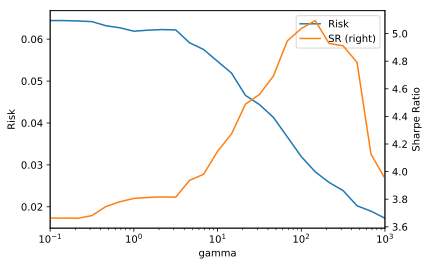

In [10]:
ax = gamma_chart[['gamma','Risk','SR']].plot(x=['gamma'], secondary_y=['SR'], logx=True)
ax.set_ylabel('Risk')
ax.right_ax.set_ylabel('Sharpe Ratio');

          0.0     0.2     0.4     0.6     0.8     1.0
count  60.000  60.000  60.000  60.000  60.000  60.000
mean    0.003   0.002   0.001   0.001   0.002   0.001
std     0.006   0.006   0.006   0.007   0.009   0.011
min    -0.007  -0.013  -0.023  -0.026  -0.029  -0.035
25%    -0.001  -0.001  -0.000  -0.002  -0.002  -0.003
50%     0.000   0.000   0.000   0.002   0.003   0.002
75%     0.006   0.004   0.005   0.006   0.006   0.006
max     0.024   0.021   0.014   0.017   0.020   0.024


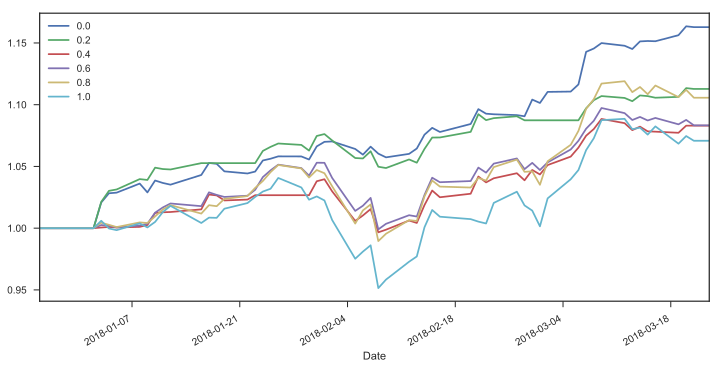

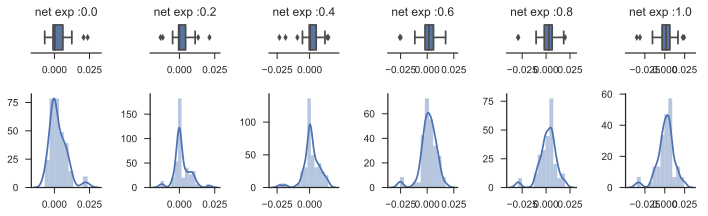

In [320]:
# 3. what is the optimal net exposure, weekly rebalance during 2018?
time_frame = '2017-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary2(net_exp_port)
    # conclusion: see that the net exposure equal to zero acheives the best return with the smallest drawdown
    
except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    net_exp_portfolios = pd.DataFrame([])
    log = True
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

In [12]:
# creates portfolio risk metric matrix to determine best net exposure
port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
risk_matrix = net_exp_port.apply(port_risk_matrix)
risk_matrix

0.0       0.2       0.4       0.6       0.8       1.0
Return   0.154604  0.109630  0.082391  0.083081  0.104619  0.072950
Risk     0.046265  0.043146  0.050593  0.058359  0.069928  0.082710
RSpread  0.108340  0.066484  0.031798  0.024722  0.034691 -0.009761
Sharpe   3.341745  2.540901  1.628520  1.423615  1.496102  0.881991
MaxDraw -0.012038 -0.025563 -0.041364 -0.051248 -0.058636 -0.085731

In [13]:
net_exposure = float(risk_matrix.loc['RSpread'].argmax())
net_exposure

0.0

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean      0.000     0.000     0.000     0.000     0.000     0.000
std       0.010     0.009     0.008     0.008     0.006     0.006
min      -0.110    -0.098    -0.082    -0.085    -0.045    -0.036
25%      -0.003    -0.003    -0.003    -0.003    -0.002    -0.002
50%       0.000     0.000     0.000     0.000     0.000     0.000
75%       0.004     0.004     0.004     0.004     0.003     0.003
max       0.065     0.053     0.051     0.048     0.030     0.046


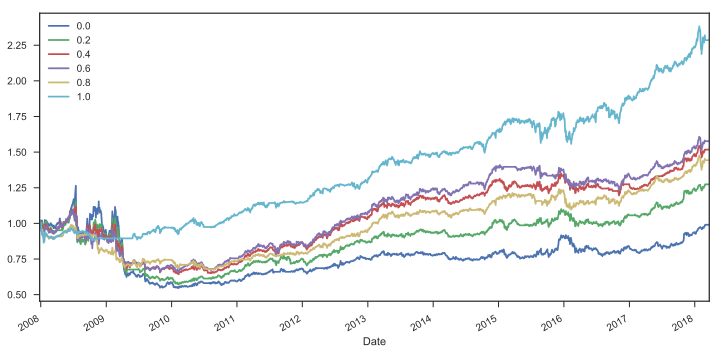

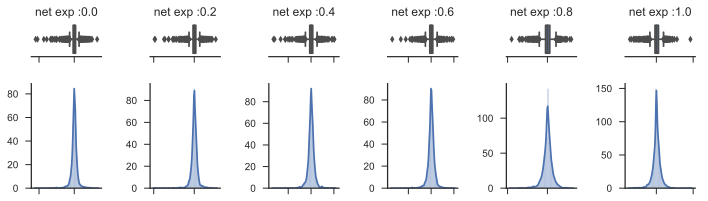

In [315]:
# 4. what are the net exposures with monthly rebalances?
time_frame = '2007-12-25'; rebal_frequency = 'BM'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary2(net_exp_port)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

'BHF'

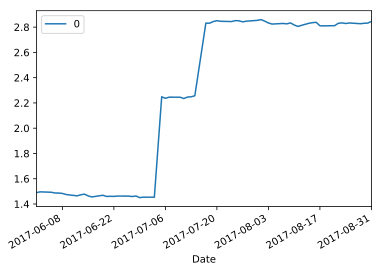

In [15]:
# recreate performance for a given net exposure
ne = '0.8'
fname = FNAME_ALLOC.format(BACKTEST_PATH, ne, time_frame, rebal_frequency)
allocs = pd.read_csv(fname, index_col='Date', parse_dates=True)
fname = FNAME_RETURN.format(BACKTEST_PATH, ne, time_frame, rebal_frequency)
returns = pd.read_csv(fname, index_col='Date', parse_dates=True)
time_series = calc_port_performance(returns, allocs).to_frame()
ts, te = '2017-06', '2017-08'
time_series[ts:te].plot()
returns.loc[returns[ts:te].abs().max(axis=1).argmax()].argmax()

In [18]:
# since there are two jumps, run this code twice
ts = net_exp_port[ne].pct_change().argmax()
date_idx = ts.strftime('%F')
i = len(net_exp_port[ne].loc[:date_idx])
index_val = net_exp_port[ne].iloc[i - 2]
adjusted = compound(net_exp_port[ne].loc[date_idx:]) * index_val
net_exp_port[ne].loc[adjusted.index] = adjusted.values

In [19]:
time_frame = '2007-12-25'; rebal_frequency = 'BM'
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)
net_exp_port.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean     -0.000     0.000     0.000     0.000     0.000     0.000
std       0.009     0.008     0.007     0.008     0.006     0.006
min      -0.104    -0.097    -0.082    -0.085    -0.046    -0.041
25%      -0.003    -0.003    -0.003    -0.003    -0.003    -0.002
50%       0.000     0.000     0.000     0.000     0.000     0.000
75%       0.003     0.003     0.004     0.004     0.003     0.003
max       0.058     0.044     0.042     0.051     0.035     0.047


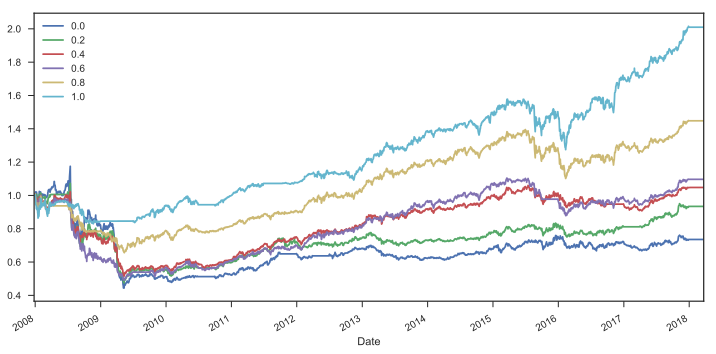

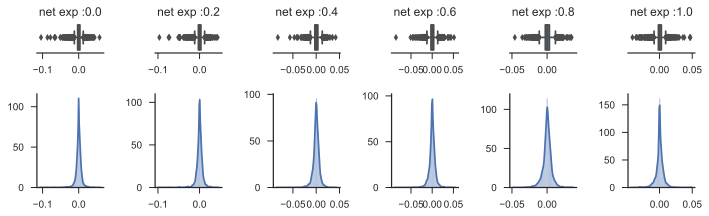

In [309]:
# 4. what are the net exposures with quarterly rebalances?
time_frame = '2007-12-25'; rebal_frequency = 'BQ'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    hist_alloc = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary2(net_exp_port)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean      0.001     0.001     0.001     0.001     0.001     0.001
std       0.010     0.008     0.007     0.007     0.006     0.005
min      -0.098    -0.095    -0.093    -0.076    -0.035    -0.039
25%      -0.002    -0.002    -0.002    -0.002    -0.002    -0.001
50%       0.001     0.001     0.001     0.001     0.001     0.000
75%       0.005     0.004     0.004     0.004     0.003     0.003
max       0.075     0.058     0.047     0.042     0.037     0.040


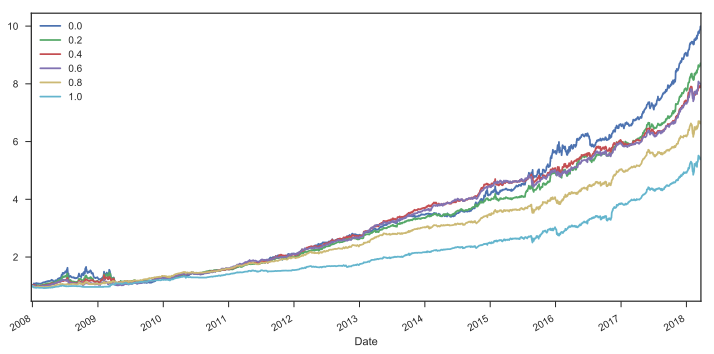

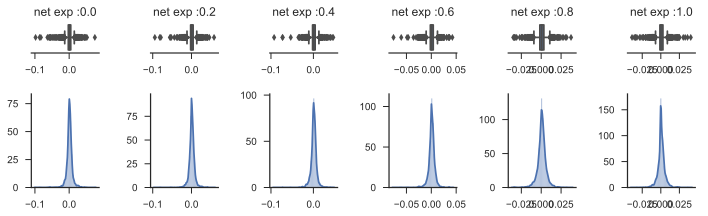

In [310]:
# 4. what are the net exposures with weekly rebalances?
log = True
time_frame = '2007-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary2(net_exp_port)
    # conclusion: see that the 0 net exposure acheives the best "cumulative" returns
    # however, there are a fair amount of outliers in the boxplot
    # need to decompose into years to understand the behaviour

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

           0.0      0.2      0.4      0.6      0.8      1.0
count  252.000  252.000  252.000  252.000  252.000  252.000
mean     0.001    0.001    0.001    0.000    0.000   -0.000
std      0.018    0.014    0.012    0.011    0.008    0.004
min     -0.086   -0.082   -0.072   -0.061   -0.025   -0.032
25%     -0.006   -0.005   -0.005   -0.004   -0.003   -0.001
50%      0.002    0.000    0.001    0.001    0.000    0.000
75%      0.010    0.008    0.007    0.006    0.004    0.001
max      0.075    0.058    0.047    0.035    0.032    0.014
           0.0      0.2      0.4      0.6      0.8      1.0
count  251.000  251.000  251.000  251.000  251.000  251.000
mean     0.000    0.001    0.001    0.001    0.001    0.001
std      0.017    0.015    0.013    0.012    0.008    0.006
min     -0.098   -0.095   -0.093   -0.076   -0.035   -0.014
25%     -0.004   -0.003   -0.004   -0.003   -0.002   -0.001
50%      0.001    0.000    0.001    0.001    0.001    0.000
75%      0.006    0.005    0.006    0.00

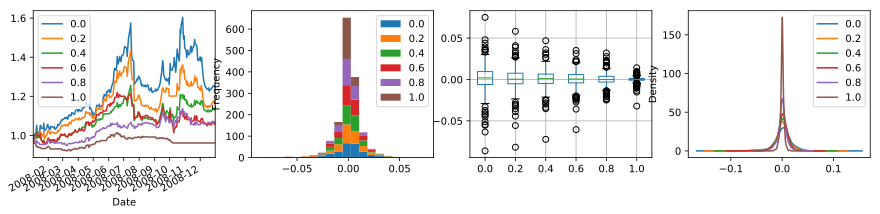

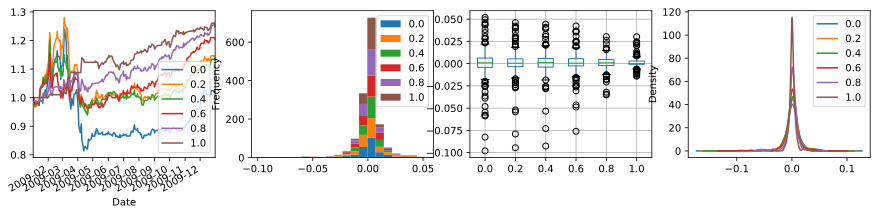

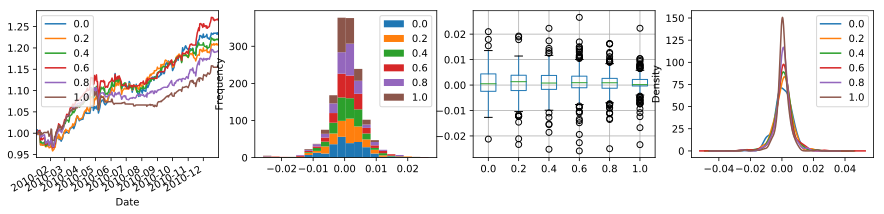

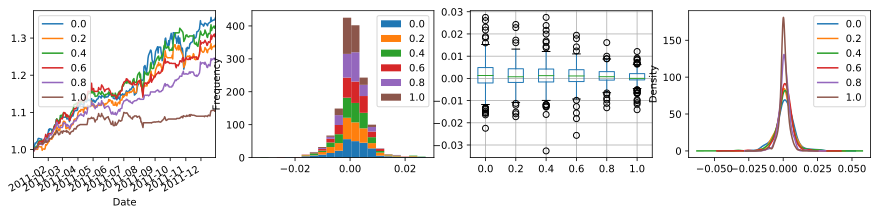

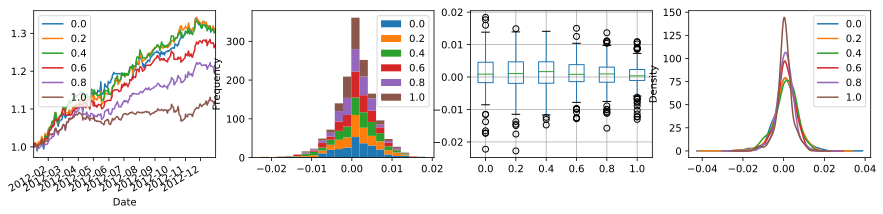

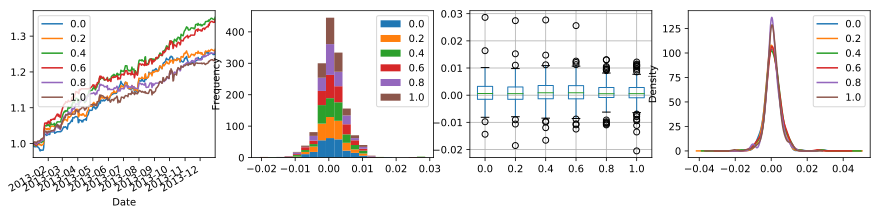

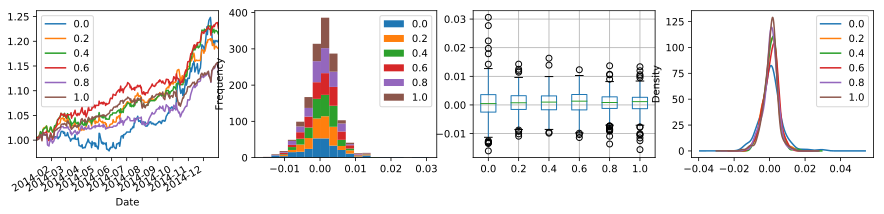

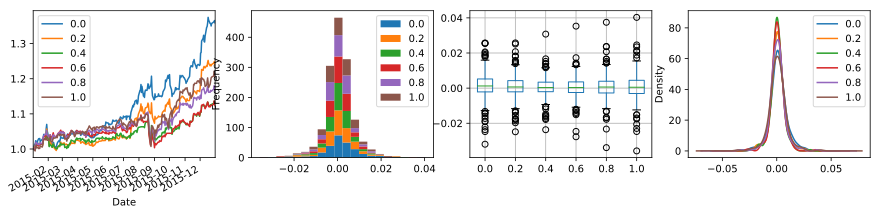

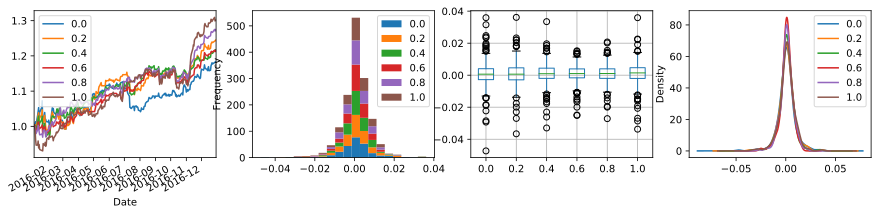

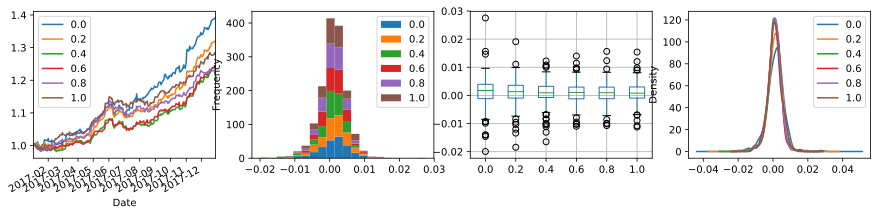

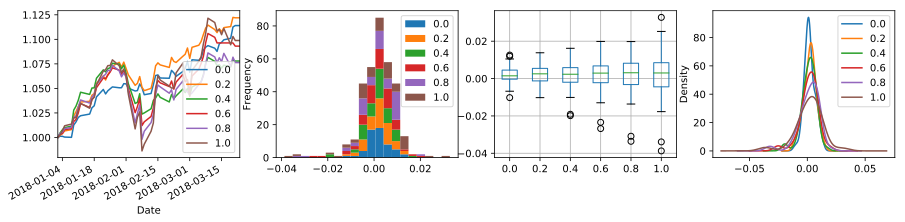

In [22]:
# to better understand charts, decompose the performance into years
net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
net_exp_port.columns = left_substr(net_exp_port, 3)
years = net_exp_port.index.year.drop_duplicates()
nbr_charts = len(sorted(years)); cols = 5
for i in years:
    if i < 2008: continue
    year_df = net_exp_port.loc[str(i)] 
    plot_bt_summary2(year_df)
# conclusions: WIP, fixed exposures does work every year, need to dynamically determine with argmax

In [ ]:
# 5. how does the optimal net exposure behave over time, 10 years, does it change over time?
# PENDING



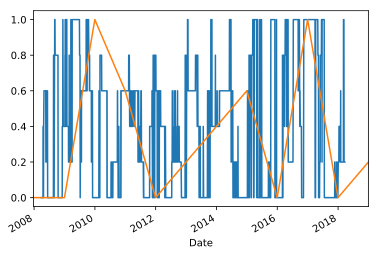

In [24]:
# what is the best net exposure by year, is it dynamic?
# PENDING
roll3M = (net_exp_port/ net_exp_port.shift(60)) - 1
cum_period_return = net_exp_port.pct_change().resample('A').sum()

best_ne = lambda x: np.argmax(x)

# plot the rolling average net exposure vs. the best for the year
roll3M.apply(best_ne, axis='columns').astype(np.float).plot()
ax = cum_period_return.apply(best_ne, axis='columns').astype(np.float).plot()

# conclusions: WIP, yes, best returns come from adjusting net exposures overtime
# need to come up with a framework to adjust net exposure to maximize returns

In [26]:
## estimacion de precios de las compañias

try:
    est_last_days = pd.read_csv("estimaciones_precios.csv", index_col='ds', parse_dates=True)

except Exception as err:
    # forecast para todas las compañias 
    est_last_days=consol_px.apply(est_price,axis=0)
    est_last_days.to_csv("estimaciones_precios.csv")

In [29]:
est_last_days.head()

A        AAL        AAP       AAPL       ABBV        ABC  \
ds                                                                             
2007-11-16  25.019690  15.318129  32.657931  17.673417  29.590403  18.726394   
2007-11-19  24.865174  15.012815  32.653133  17.589476  29.530211  18.726337   
2007-11-20  24.824835  14.990720  32.710533  17.538944  29.525709  18.754963   
2007-11-21  24.803383  14.926367  32.766841  17.521646  29.516147  18.755154   
2007-11-23  24.719970  14.942878  32.909238  17.435773  29.523103  18.767779   

                  ABT        ACN       ADBE        ADI    ...            XEL  \
ds                                                        ...                  
2007-11-16  17.628110  27.241795  43.302928  22.138435    ...      14.954711   
2007-11-19  17.576598  27.224100  42.713349  22.079144    ...      14.882915   
2007-11-20  17.564730  27.264980  42.555687  22.098663    ...      14.871213   
2007-11-21  17.534644  27.272512  42.420307  22.106647    ...      14.842168   
2007-11-23  17.507064  27.311948  42.191399  22.072347    ...      14.822045   

                 XLNX        XOM       XRAY        XRX        XYL        YUM  \
ds                                                                             
2007-11-16  15.810403  66.222095  42.054152  32.282399  22.596160  21.685401   
2007-11-19  15.845783  66.202752  41.708925  32.335490  22.537936  21.694934   
2007-11-20  15.879494  66.339135  41.664980  32.377412  22.535887  21.707725   
2007-11-21  15.911405  66.313779  41.594686  32.412577  22.521668  21.714509   
2007-11-23  15.944572  66.305629  41.465778  32.546351  22.502448  21.756887   

                  ZBH       ZION        ZTS  
ds                                           
2007-11-16  62.476681  48.382946  29.934894  
2007-11-19  62.307213  47.908497  29.966305  
2007-11-20  62.369475  47.796082  29.975728  
2007-11-21  62.305811  47.787470  29.984439  
2007-11-23  62.311090  47.785939  30.022886  

[5 rows x 495 columns]

          0.0     0.2     0.4     0.6     0.8     1.0
count  52.000  52.000  52.000  52.000  52.000  52.000
mean   -0.000  -0.001  -0.001  -0.001   0.000  -0.000
std     0.024   0.019   0.021   0.019   0.016   0.017
min    -0.156  -0.133  -0.129  -0.112  -0.067  -0.063
25%    -0.002  -0.001  -0.002  -0.004  -0.005  -0.006
50%     0.000   0.001   0.000   0.001   0.001   0.001
75%     0.005   0.004   0.004   0.005   0.006   0.006
max     0.048   0.013   0.037   0.039   0.049   0.044


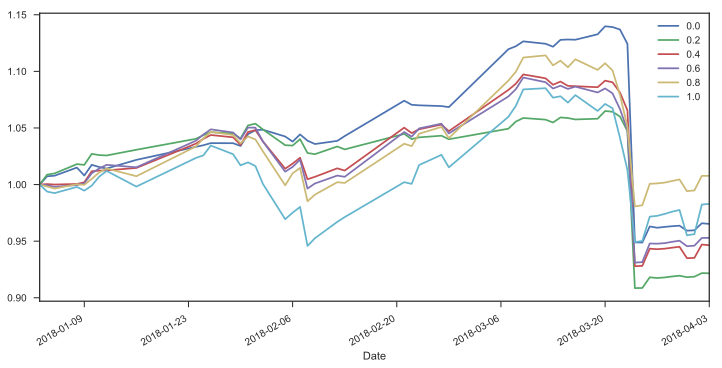

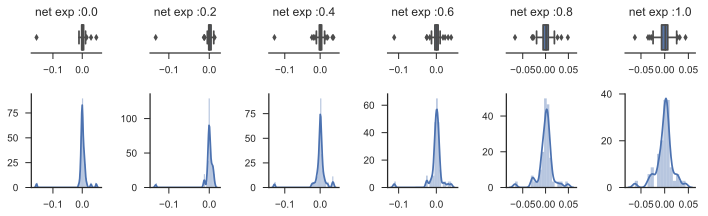

In [311]:
### análisis de net exposure con una proyeccion de precios de una semana
time_frame = '2017-12-25'; rebal_frequency = 'W-WED'
subset0 = consol_px[time_frame:]      ### datos de precios reales
subset1 = est_last_days['2018-03-24':] ### datos de estimaciones a lo largo del tiempo
subset2=subset1.combine_first(subset0) 
subset2.index.name="Date"
subset2.head()

suf = 'estimacion-2017-12-25'; 
fname = FNAME_INDEX.format(BACKTEST_PATH, suf, rebal_frequency)

try:
    net_exp_portfolios = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_portfolios.columns = left_substr(net_exp_portfolios, 3)
    plot_bt_summary2(net_exp_portfolios.dropna())  ### la proyeccion esta muy extraña 
except Exception as err:
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset2, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset2)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, suf, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, suf, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, suf, rebal_frequency))


In [ ]:
#### Quitar los valores extremos de la distribucion general de retornos, quitar las compañias

